### ROC

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
root_path = "../output/baseline"
class_label_to_calculate = 1
metric_list = os.listdir(root_path)
metric_list = ['Blastp.npz', 'ESM.npz', 'DeepTFpredict.npz', 'GAT.npz', 'GCN.npz', 'GTN.npz', 'FM-HGN.npz']

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(file_path, class_label=1):
    # Load the saved data
    loaded_data = np.load(file_path)

    # Access the saved arrays using the corresponding keys
    if 'label' in list(loaded_data.keys()):
        labels = loaded_data['label']
        probabilities = loaded_data['prob']
    elif 'labels' in list(loaded_data.keys()):
        labels = loaded_data['labels']
        probabilities = loaded_data['predictions']    
    elif 'groundtruth' in list(loaded_data.keys()):
        labels = loaded_data['groundtruth']
        probabilities = loaded_data['predict']
    # Calculate predicted labels
    if len(probabilities.shape) >= 2:
        predicted_labels = np.argmax(probabilities, axis=1)
    else:
        predicted_labels = probabilities

    if len(labels.shape) >= 2:
        labels = np.argmax(labels, axis=1)
    else:
        labels = labels

    # Calculate precision, recall, and F1-score for the specified class
    precision = precision_score(labels, predicted_labels, pos_label=class_label)
    recall = recall_score(labels, predicted_labels, pos_label=class_label)
    f1 = f1_score(labels, predicted_labels, pos_label=class_label)

    # Calculate ROC curve
    try:
        if file_path=="../output/baseline/GAT.npz":
            global a 
            global b
            a = labels
            b = probabilities
            
        fpr, tpr, thresholds = roc_curve(labels, probabilities[:, class_label])
        roc_auc = auc(fpr, tpr)
    except:
        fpr, tpr, roc_auc = 0, 0, 0

    return precision, recall, f1, fpr, tpr, roc_auc

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1-Score', 'AUC'])

# Function to calculate metrics and update the DataFrame
def update_result_df(file_path, class_label=1):
    precision, recall, f1, fpr, tpr, roc_auc = calculate_metrics(file_path, class_label)
    return pd.Series({'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': roc_auc})

# Iterate through each file in metric_list
for metric_file in metric_list:
    file_path = os.path.join(root_path, metric_file)

    # Skip non-npz files
    if not metric_file.endswith('.npz'):
        continue

    # Calculate metrics and append the results to the DataFrame
    result_df.loc[metric_file.replace(".npz", "")] = update_result_df(file_path, class_label_to_calculate)
result_df.to_csv("result/baseline.csv")
result_df

,Precision,Recall,F1-Score,AUC
Blastp,0.916667,0.354839,0.511628,0.000000
ESM,0.243243,0.145161,0.181818,0.841905
DeepTFpredict,0.808219,0.951613,0.874074,0.000000
GAT,0.469388,0.348485,0.400000,0.846420
GCN,0.733333,0.333333,0.458333,0.896058
GTN,0.319527,0.818182,0.459574,0.892108
FM-HGN,0.983607,0.909091,0.944882,0.961331


In [2]:
# # Iterate through each file in metric_list
# for metric_file in metric_list:
#     file_path = os.path.join(root_path, metric_file)

#     # Skip non-npz files
#     if not metric_file.endswith('.npz'):
#         continue

#     # Calculate metrics and append the results to the DataFrame
#     result_df.loc[metric_file.replace(".npz", "")] = update_result_df(file_path, 0)
# result_df

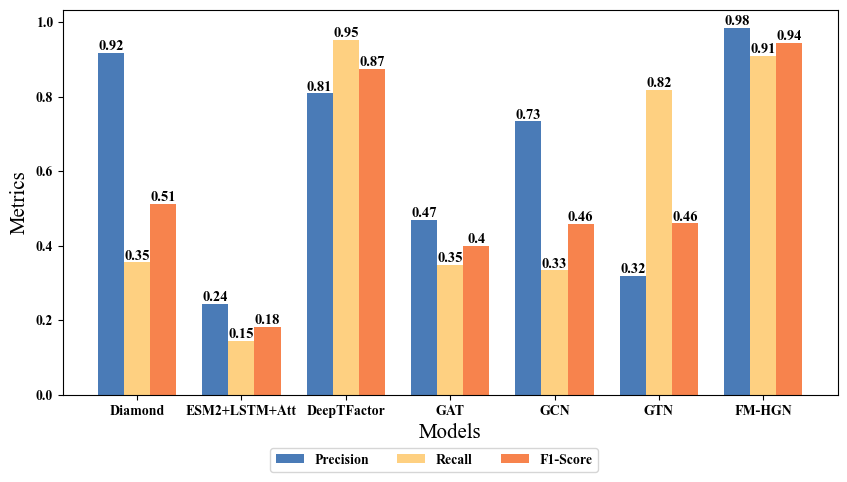

In [3]:
import matplotlib.pyplot as plt

# Index representing the models
models = ['Diamond', 'ESM2+LSTM+Att', 'DeepTFactor', 'GAT', 'GCN', 'GTN', 'FM-HGN']

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.25
bar_positions = [i for i in range(len(models))]
colors = ['#4A7BB7', '#FED081', '#F7834D']
for i, metric in enumerate(['Precision', 'Recall', 'F1-Score']):
    bars = ax.bar([pos + i * bar_width for pos in bar_positions], result_df[metric], width=bar_width, label=metric, color=colors[i])
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black', fontsize=10.5)
        
# Customize plot
ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(models)
ax.set_xlabel('Models',size=15)
ax.set_ylabel('Metrics',size=15)
# ax.set_title('Comparison of Transcription Factor Prediction Metrics')
ax.legend(bbox_to_anchor=(0.7, -0.12),ncol=3)
plt.savefig("plot/baseline.png", dpi=600, bbox_inches = 'tight')
plt.show()

In [4]:
metric_list

['Blastp.npz',
 'ESM.npz',
 'DeepTFpredict.npz',
 'GAT.npz',
 'GCN.npz',
 'GTN.npz',
 'FM-HGN.npz']

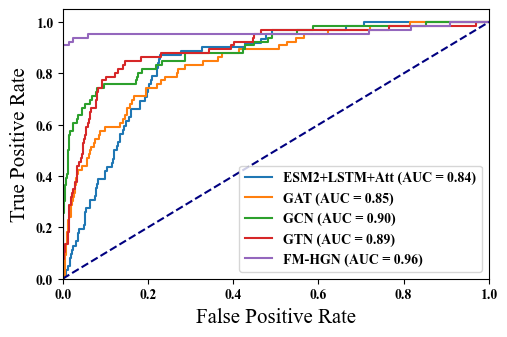

In [7]:
# Plot ROC curves for each model
plt.figure(figsize=(5.5, 3.5))
for metric_file in metric_list:
    model_name = metric_file.replace(".npz", "")
    file_path = os.path.join(root_path, metric_file)
    # Skip non-npz files
    if not metric_file.endswith('.npz') or (metric_file in ['Blastp.npz','DeepTFpredict.npz']):
        continue

    _, _, _, fpr, tpr, _ = calculate_metrics(file_path, class_label_to_calculate)
    plt.plot(fpr, tpr, label=f'{"ESM2+LSTM+Att" if model_name=="ESM" else model_name} (AUC = {result_df.loc[model_name]["AUC"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.legend(loc="lower right")
plt.savefig("plot/roc.png", dpi=600, bbox_inches = 'tight')
plt.show()